# Overview

In this example, we are going to predict the binding pose of a small molecule to a target protein.

PDB 6HD6 is an interesting case, in which two small molecule drugs bind to the same protein target on different binding sites.

One small molecule, STI-571, is the famous drug Imatinib. The other small molecule, FYH, is asciminib.

This PDB is also used as an exmaple by Regina Barzilay and Hannes Stärk in MLDD workshop https://www.mldd-workshop.org/home

https://www.rcsb.org/structure/6HD6

In [1]:
tankbind_src_folder_path = "../tankbind/"
import sys
sys.path.insert(0, tankbind_src_folder_path)

# input preparation.

In [2]:
from Bio.PDB.PDBList import PDBList   # pip install biopython if import failure
import os
import numpy as np
import pandas as pd
pre = "./single_PDB_6hd6/"
pdir = f"{pre}/PDBs/"
pdb = '6hd6'
os.system(f"mkdir -p {pdir}")
pdbl = PDBList()
native_pdb = pdbl.retrieve_pdb_file(pdb, pdir=pdir, file_format='pdb')

Structure exists: './single_PDB_6hd6//PDBs/pdb6hd6.ent' 


In [3]:
import nglview   # conda install nglview -c conda-forge if import failure

In [ ]:
view = nglview.show_file(nglview.FileStructure(native_pdb))
view

In [ ]:
view.render_image()

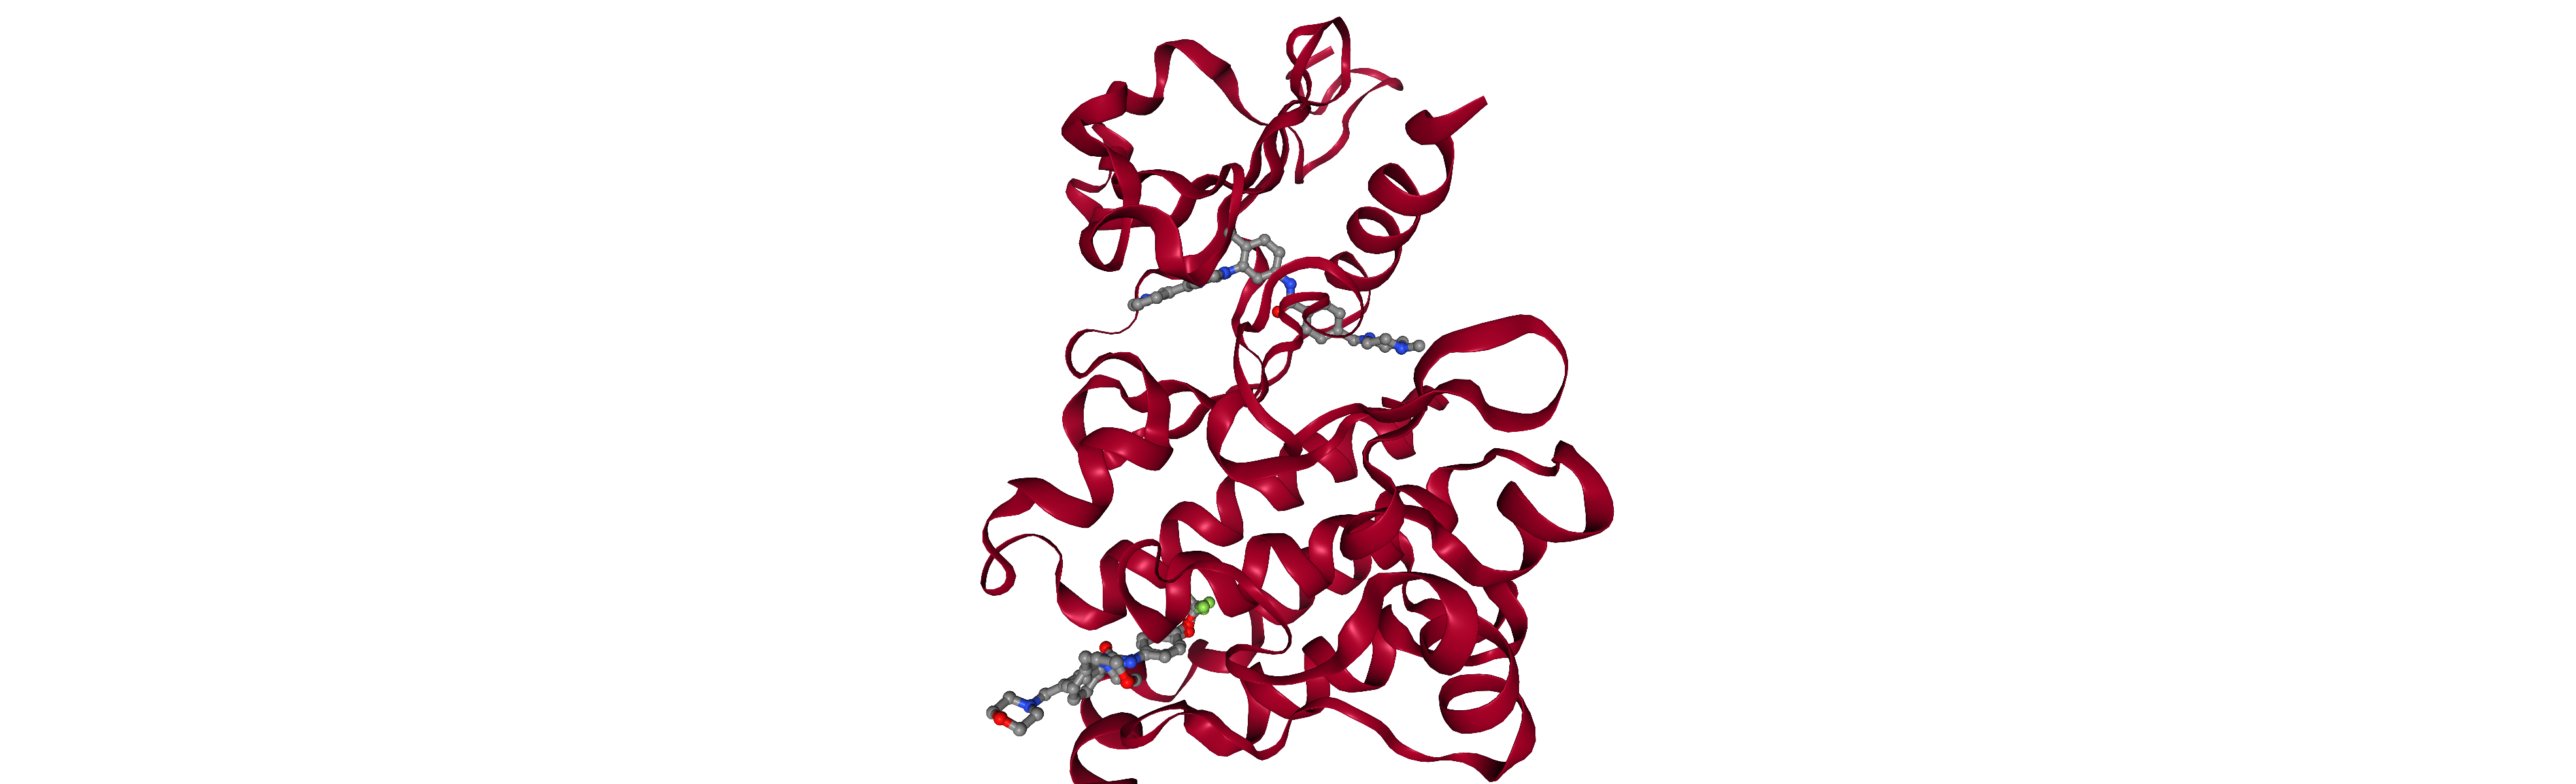

In [6]:
view._display_image()

In [4]:
from Bio.PDB import PDBParser
parser = PDBParser(QUIET=True)
s = parser.get_structure(pdb, native_pdb)

In [5]:
list(s.get_chains())

[<Chain id=A>, <Chain id=B>]

In [6]:
# model 0, chain A is the chain in contact with the ligands
c = s[0]['A']

In [7]:
# list HETATMs
res_list = list(c.get_residues())
hetro_list = [res for res in res_list if (res.full_id[-1][0] != ' ' and res.full_id[-1][0] != 'W')]
hetro_list

[<Residue CL het=H_CL resseq=601 icode= >,
 <Residue FYH het=H_FYH resseq=602 icode= >,
 <Residue STI het=H_STI resseq=603 icode= >]

In [8]:
# both FYH and STI are the ligands we are interested.

# get protein.pdb, ligand.sdf, ligand_from_rdkit.sdf ready

In [9]:
from feature_utils import split_protein_and_ligand

In [10]:
# save cleaned protein.
ligand_seq_id = 602
proteinFile = f"{pre}/{pdb}_protein.pdb"
ligandFile = f"{pre}/{pdb}_FYH_ligand.sdf"
clean_res_list, ligand_list = split_protein_and_ligand(c, pdb, ligand_seq_id, proteinFile, ligandFile)

In [11]:
ligand_seq_id = 603
ligandFile = f"{pre}/{pdb}_STI_ligand.sdf"
clean_res_list, ligand_list = split_protein_and_ligand(c, pdb, ligand_seq_id, proteinFile, ligandFile)

In [12]:
import rdkit.Chem as Chem
from feature_utils import generate_sdf_from_smiles_using_rdkit

In [13]:
# we also generated a sdf file using RDKit.
ligandFile = f"{pre}/{pdb}_STI_ligand.sdf"
smiles = Chem.MolToSmiles(Chem.MolFromMolFile(ligandFile))
rdkitMolFile = f"{pre}/{pdb}_STI_mol_from_rdkit.sdf"
shift_dis = 0   # for visual only, could be any number, shift the ligand away from the protein.
generate_sdf_from_smiles_using_rdkit(smiles, rdkitMolFile, shift_dis=shift_dis)

In [14]:
# we also generated a sdf file using RDKit.
ligandFile = f"{pre}/{pdb}_FYH_ligand.sdf"
smiles = Chem.MolToSmiles(Chem.MolFromMolFile(ligandFile))
rdkitMolFile = f"{pre}/{pdb}_FYH_mol_from_rdkit.sdf"
shift_dis = 0   # for visual only, could be any number, shift the ligand away from the protein.
generate_sdf_from_smiles_using_rdkit(smiles, rdkitMolFile, shift_dis=shift_dis)

In [ ]:
view = nglview.show_file(nglview.FileStructure(proteinFile), default=False)
view.add_representation('cartoon', selection='protein', color='white')
rdkit = view.add_component(nglview.FileStructure(rdkitMolFile), default=False)
rdkit.add_ball_and_stick(color='red')
native = view.add_component(nglview.FileStructure(ligandFile), default=False)
native.add_ball_and_stick(color='yellow')
view

In [ ]:
# red is mol generated using RDKit, yellow is the native ligand.
view.render_image()

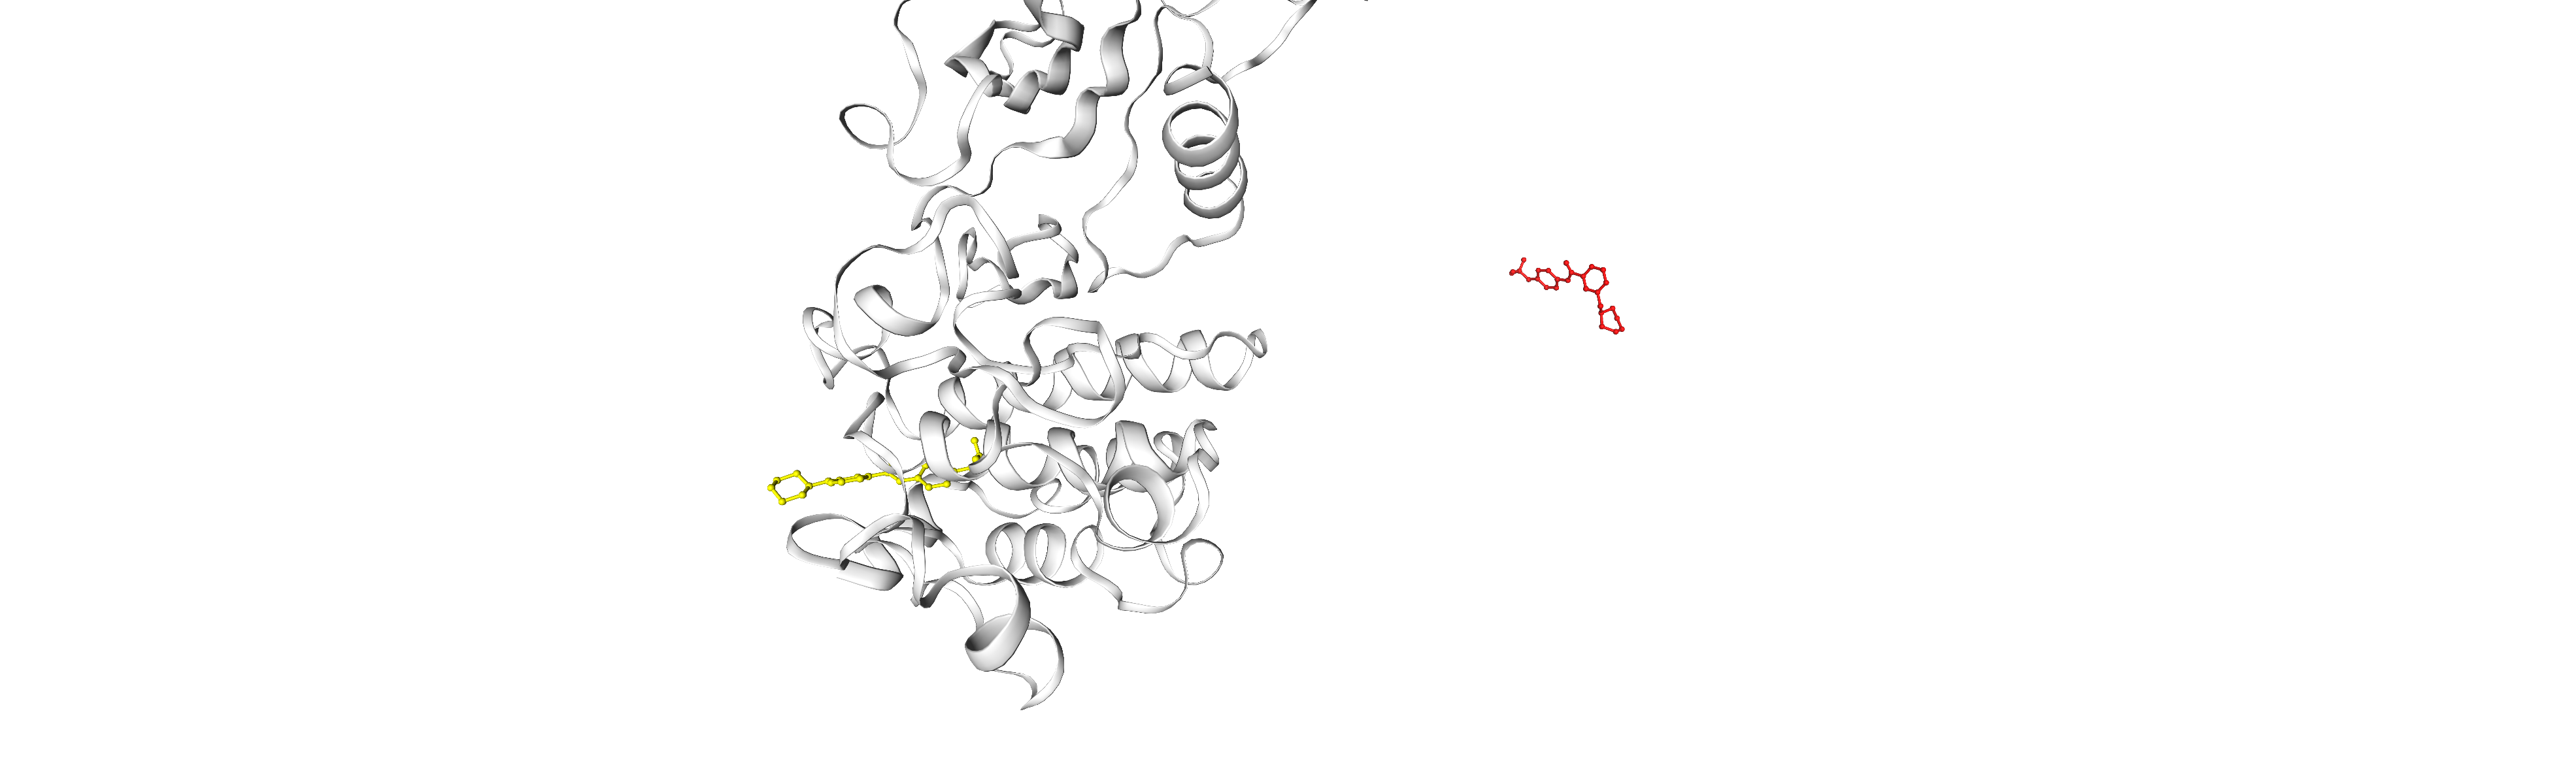

In [20]:
view._display_image()

# get protein feature

In [16]:
from feature_utils import get_protein_feature

In [17]:
parser = PDBParser(QUIET=True)
s = parser.get_structure("x", proteinFile)
res_list = list(s.get_residues())

In [18]:
protein_dict = {}
protein_dict[pdb] = get_protein_feature(res_list)


# get compound feature

In [19]:
from feature_utils import extract_torchdrug_feature_from_mol

In [20]:
compound_dict = {}
for ligandName in ['STI', 'FYH']:
    rdkitMolFile = f"{pre}/{pdb}_{ligandName}_mol_from_rdkit.sdf"
    mol = Chem.MolFromMolFile(rdkitMolFile)
    compound_dict[pdb+f"_{ligandName}"+"_rdkit"] = extract_torchdrug_feature_from_mol(mol, has_LAS_mask=True)

# p2rank

In [21]:
pdb_list = [pdb]
ds = f"{pre}/protein_list.ds"
with open(ds, "w") as out:
    for pdb in pdb_list:
        out.write(f"./{pdb}_protein.pdb\n")


In [22]:
p2rank = "bash /packages/p2rank_2.3/prank"
cmd = f"{p2rank} predict {ds} -o {pre}/p2rank -threads 1"
os.system(cmd)

0

In [23]:
info = []
for pdb in pdb_list:
    for compound_name in list(compound_dict.keys()):
        # use protein center as the block center.
        com = ",".join([str(a.round(3)) for a in protein_dict[pdb][0].mean(axis=0).numpy()])
        info.append([pdb, compound_name, "protein_center", com])

        p2rankFile = f"{pre}/p2rank/{pdb}_protein.pdb_predictions.csv"
        pocket = pd.read_csv(p2rankFile)
        pocket.columns = pocket.columns.str.strip()
        pocket_coms = pocket[['center_x', 'center_y', 'center_z']].values
        for ith_pocket, com in enumerate(pocket_coms):
            com = ",".join([str(a.round(3)) for a in com])
            info.append([pdb, compound_name, f"pocket_{ith_pocket+1}", com])
info = pd.DataFrame(info, columns=['protein_name', 'compound_name', 'pocket_name', 'pocket_com'])
info

,protein_name,compound_name,pocket_name,pocket_com
0,6hd6,6hd6_STI_rdkit,protein_center,"15.746,23.565,54.818"
1,6hd6,6hd6_STI_rdkit,pocket_1,"20.691,16.697,56.311"
2,6hd6,6hd6_STI_rdkit,pocket_2,"20.243,41.418,52.346"
3,6hd6,6hd6_STI_rdkit,pocket_3,"10.161,15.802,61.654"
4,6hd6,6hd6_STI_rdkit,pocket_4,"14.8,30.117,65.358"
5,6hd6,6hd6_STI_rdkit,pocket_5,"18.961,28.224,40.251"
6,6hd6,6hd6_STI_rdkit,pocket_6,"32.53,30.08,55.506"
7,6hd6,6hd6_STI_rdkit,pocket_7,"-1.333,28.528,67.874"
8,6hd6,6hd6_STI_rdkit,pocket_8,"14.41,1.211,50.949"
9,6hd6,6hd6_FYH_rdkit,protein_center,"15.746,23.565,54.818"


# construct dataset

In [24]:
import torch
torch.set_num_threads(1)

In [25]:
from data import TankBind_prediction

In [26]:
dataset_path = f"{pre}/{pdb}_dataset/"
os.system(f"rm -r {dataset_path}")
os.system(f"mkdir -p {dataset_path}")
dataset = TankBind_prediction(dataset_path, data=info, protein_dict=protein_dict, compound_dict=compound_dict)

['single_PDB_6hd6/6hd6_dataset/processed/data.pt', 'single_PDB_6hd6/6hd6_dataset/processed/protein.pt', 'single_PDB_6hd6/6hd6_dataset/processed/compound.pt']


Processing...
Done!


In [27]:
dataset_path = f"{pre}/{pdb}_dataset/"
dataset = TankBind_prediction(dataset_path)

['single_PDB_6hd6/6hd6_dataset/processed/data.pt', 'single_PDB_6hd6/6hd6_dataset/processed/protein.pt', 'single_PDB_6hd6/6hd6_dataset/processed/compound.pt']


In [28]:
import logging
from torch_geometric.loader import DataLoader
from tqdm import tqdm    # pip install tqdm if fails.
from model import get_model
# from utils import *

In [30]:
batch_size = 5
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device= 'cpu'
logging.basicConfig(level=logging.INFO)
model = get_model(0, logging, device)
# re-dock model
# modelFile = "../saved_models/re_dock.pt"
# self-dock model
modelFile = "../saved_models/self_dock.pt"

model.load_state_dict(torch.load(modelFile, map_location=device))
_ = model.eval()

data_loader = DataLoader(dataset, batch_size=batch_size, follow_batch=['x', 'y', 'compound_pair'], shuffle=False, num_workers=8)
affinity_pred_list = []
y_pred_list = []
for data in tqdm(data_loader):
    data = data.to(device)
    y_pred, affinity_pred = model(data)
    affinity_pred_list.append(affinity_pred.detach().cpu())
    for i in range(data.y_batch.max() + 1):
        y_pred_list.append((y_pred[data['y_batch'] == i]).detach().cpu())

affinity_pred_list = torch.cat(affinity_pred_list)

23:19:45   5 stack, readout2, pred dis map add self attention and GVP embed, compound model GIN


100%|██████████| 4/4 [00:18<00:00,  4.68s/it]


In [31]:
affinity_pred_list

tensor([8.0182, 7.8629, 5.5873, 7.6644, 4.5967, 2.3402, 6.4694, 3.2241, 5.3610,
        6.2533, 6.1588, 6.7576, 5.8242, 3.4801, 2.3382, 3.0268, 2.5952, 4.2196])

In [32]:
info = dataset.data
info['affinity'] = affinity_pred_list

In [33]:
info.to_csv(f"{pre}/info_with_predicted_affinity.csv")

In [34]:
chosen = info.loc[info.groupby(['protein_name', 'compound_name'],sort=False)['affinity'].agg('idxmax')].reset_index()
chosen

,index,protein_name,compound_name,pocket_name,pocket_com,affinity
0,0,6hd6,6hd6_STI_rdkit,protein_center,"15.746,23.565,54.818",8.018212
1,11,6hd6,6hd6_FYH_rdkit,pocket_2,"20.243,41.418,52.346",6.757601


# from predicted interaction distance map to sdf

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
from generation_utils import get_LAS_distance_constraint_mask, get_info_pred_distance, write_with_new_coords
device = 'cpu'
for i, line in chosen.iterrows():
    idx = line['index']
    pocket_name = line['pocket_name']
    compound_name = line['compound_name']
    ligandName = compound_name.split("_")[1]
    coords = dataset[idx].coords.to(device)
    protein_nodes_xyz = dataset[idx].node_xyz.to(device)
    n_compound = coords.shape[0]
    n_protein = protein_nodes_xyz.shape[0]
    y_pred = y_pred_list[idx].reshape(n_protein, n_compound).to(device)
    y = dataset[idx].dis_map.reshape(n_protein, n_compound).to(device)
    compound_pair_dis_constraint = torch.cdist(coords, coords)
    rdkitMolFile = f"{pre}/{pdb}_{ligandName}_mol_from_rdkit.sdf"
    mol = Chem.MolFromMolFile(rdkitMolFile)
    LAS_distance_constraint_mask = get_LAS_distance_constraint_mask(mol).bool()
    info = get_info_pred_distance(coords, y_pred, protein_nodes_xyz, compound_pair_dis_constraint, 
                                  LAS_distance_constraint_mask=LAS_distance_constraint_mask,
                                  n_repeat=1, show_progress=False)

    result_folder = f'{pre}/{pdb}_result/'
    os.system(f'mkdir -p {result_folder}')
    # toFile = f'{result_folder}/{ligandName}_{pocket_name}_tankbind.sdf'
    toFile = f'{result_folder}/{ligandName}_tankbind.sdf'
    # print(toFile)
    new_coords = info.sort_values("loss")['coords'].iloc[0].astype(np.double)
    write_with_new_coords(mol, new_coords, toFile)

In [ ]:
view = nglview.show_file(nglview.FileStructure(proteinFile), default=False)
view.add_representation('cartoon', selection='protein', color='white')


for ligandName in ['STI', 'FYH']:
    predictedFile = f'{result_folder}/{ligandName}_tankbind.sdf'
    rdkit = view.add_component(nglview.FileStructure(predictedFile), default=False)
    rdkit.add_ball_and_stick(color='red')
    ligandFile = f"{pre}/{pdb}_{ligandName}_ligand.sdf"
    native = view.add_component(nglview.FileStructure(ligandFile), default=False)
    native.add_ball_and_stick(color='yellow')
view

In [ ]:
# red is prediction starting from mol generated using RDKit, yellow is the native ligand.
view.render_image()

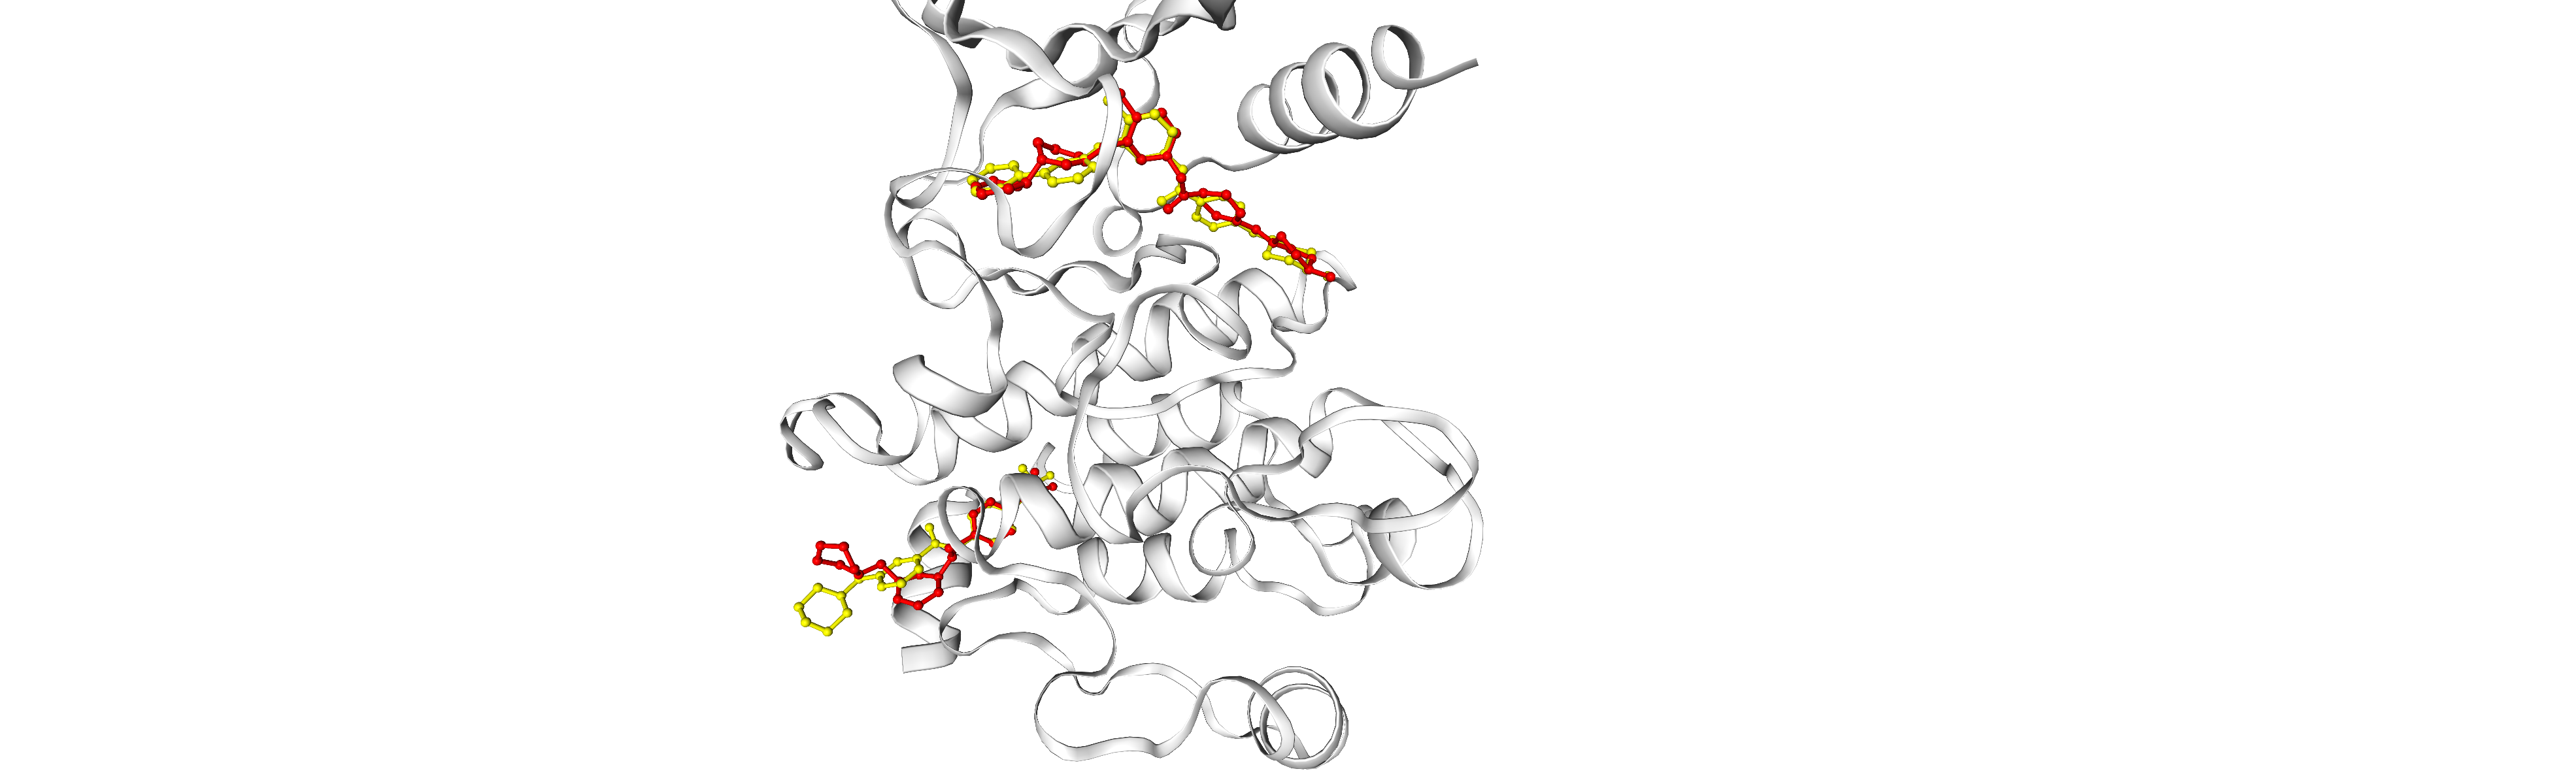

In [43]:
view._display_image()